In [5]:
from tsfresh import extract_features, extract_relevant_features
from tsfresh.feature_extraction import EfficientFCParameters
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
data_o = pd.read_csv('Untitled Folder/AirPassengers.csv')
print(data_o.shape)
data_o.head()

(144, 2)


,time,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
# setting params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sns.set_style('whitegrid')
sns.set_context('talk')

plt.rcParams.update(params)

# Time series features Data analysis with visualization

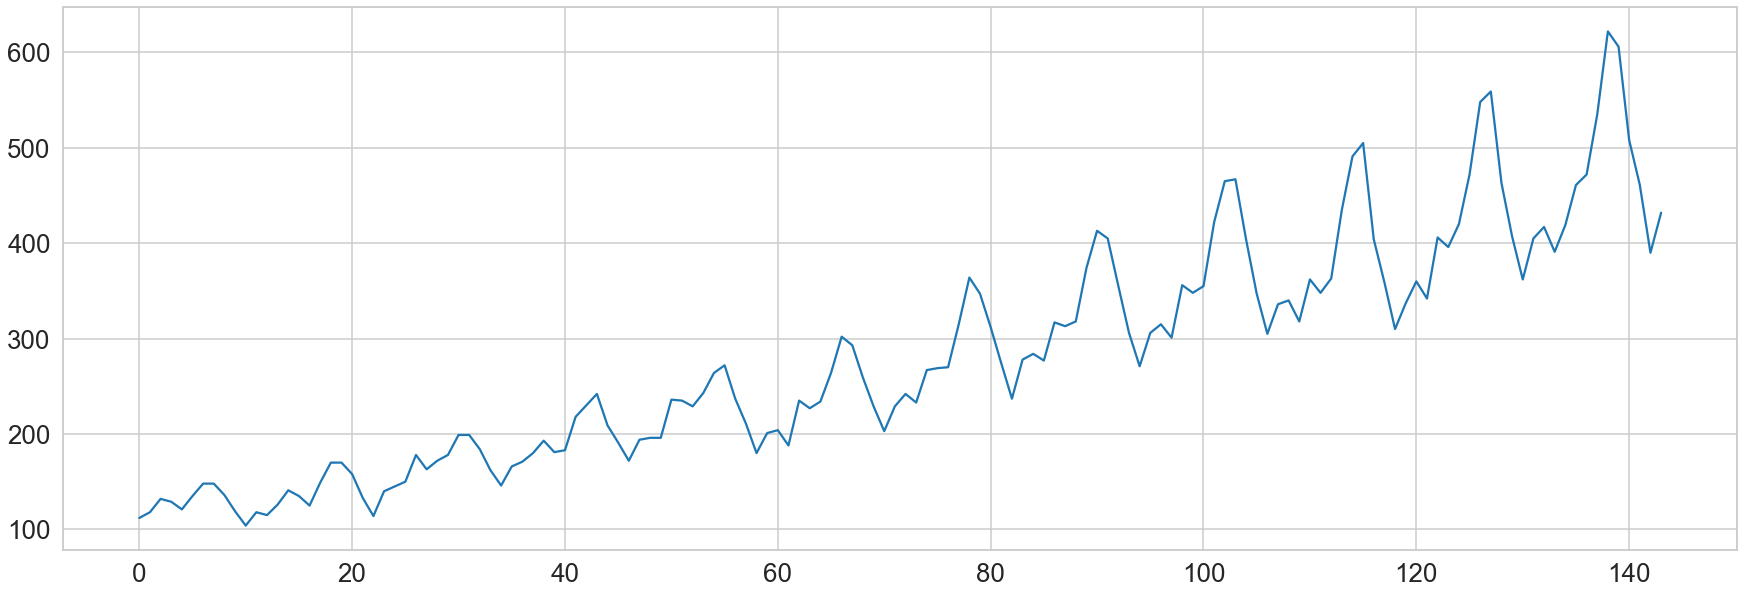

In [9]:
data = data_o['passengers']
plt.plot(data)

#Looking at below plot we can see an upward montly trend and also sesaonality, i.e it seems like as time passes
# passengers who are taking flights are increasing, but to be concrete lets plot by dates by engineering date features.

In [10]:
# Convert timestamp into a pandas datatime object, we will work with montly frequency only
data_o['time'] = pd.to_datetime(data_o['time'])
data_o = data_o.set_index('time')
# There are no missing values
# feature engineering: creating date features.
data_o['month'] = data_o.index.month
data_o['quarter'] = data_o.index.quarter
data_o['year'] = data_o.index.year #12 unique years
data_o.head()


,passengers,month,quarter,year
time,,,,
1949-01-01,112,1,1,1949
1949-02-01,118,2,1,1949
1949-03-01,132,3,1,1949
1949-04-01,129,4,2,1949
1949-05-01,121,5,2,1949


[Text(0.5, 1.0, 'Monthly distribution of Passengers')]

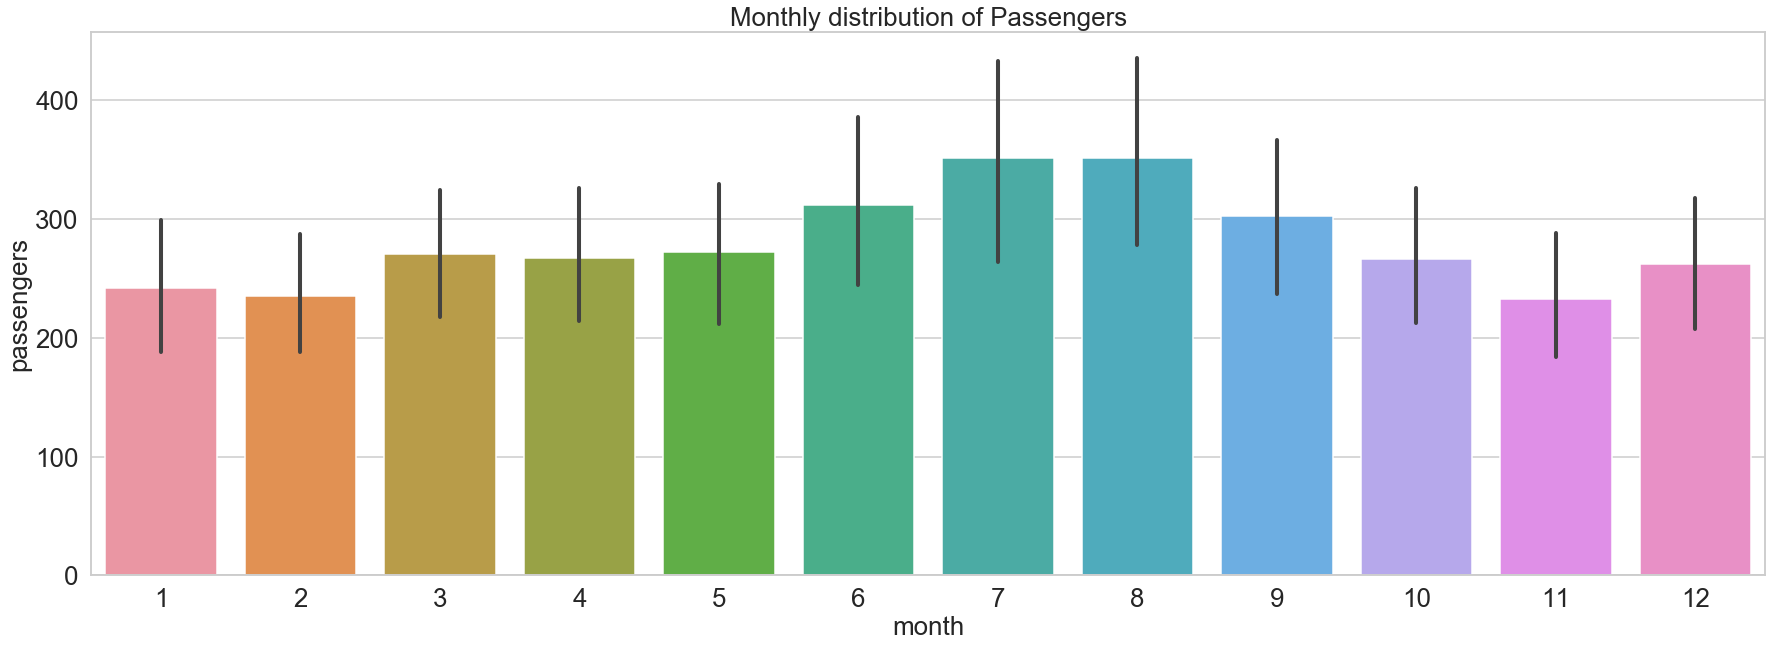

In [6]:
ax= sns.barplot(data=data_o,x="month",y="passengers")
#ax.set(ylim=(0, 60000))
ax.set(title="Monthly distribution of Passengers")

[Text(0.5, 1.0, 'quarterly distribution of Passengers')]

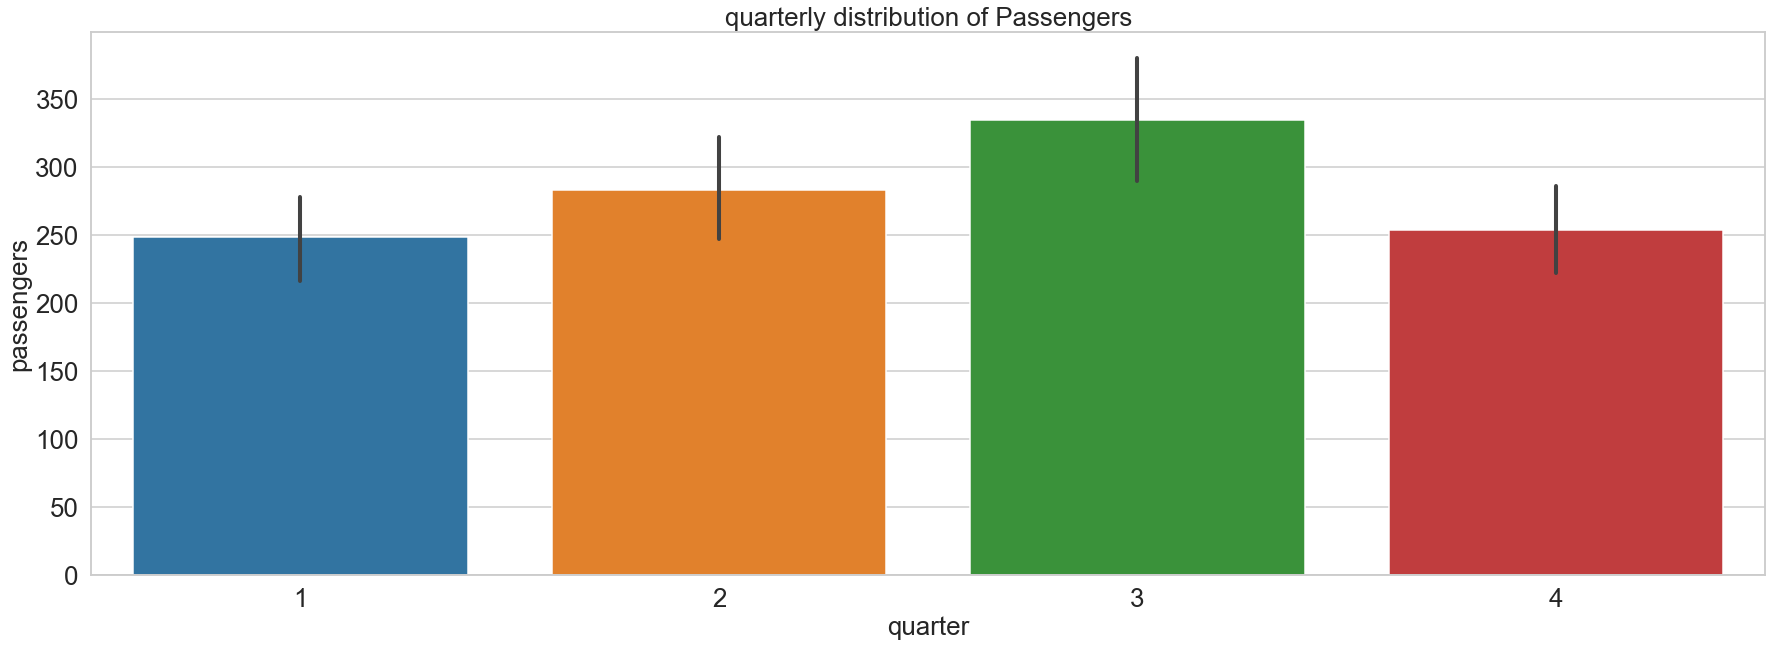

In [7]:
ax= sns.barplot(data=data_o,x="quarter",y="passengers")
#ax.set(ylim=(0, 60000))
ax.set(title="quarterly distribution of Passengers")

[Text(0.5, 1.0, 'yearly distribution of Passengers')]

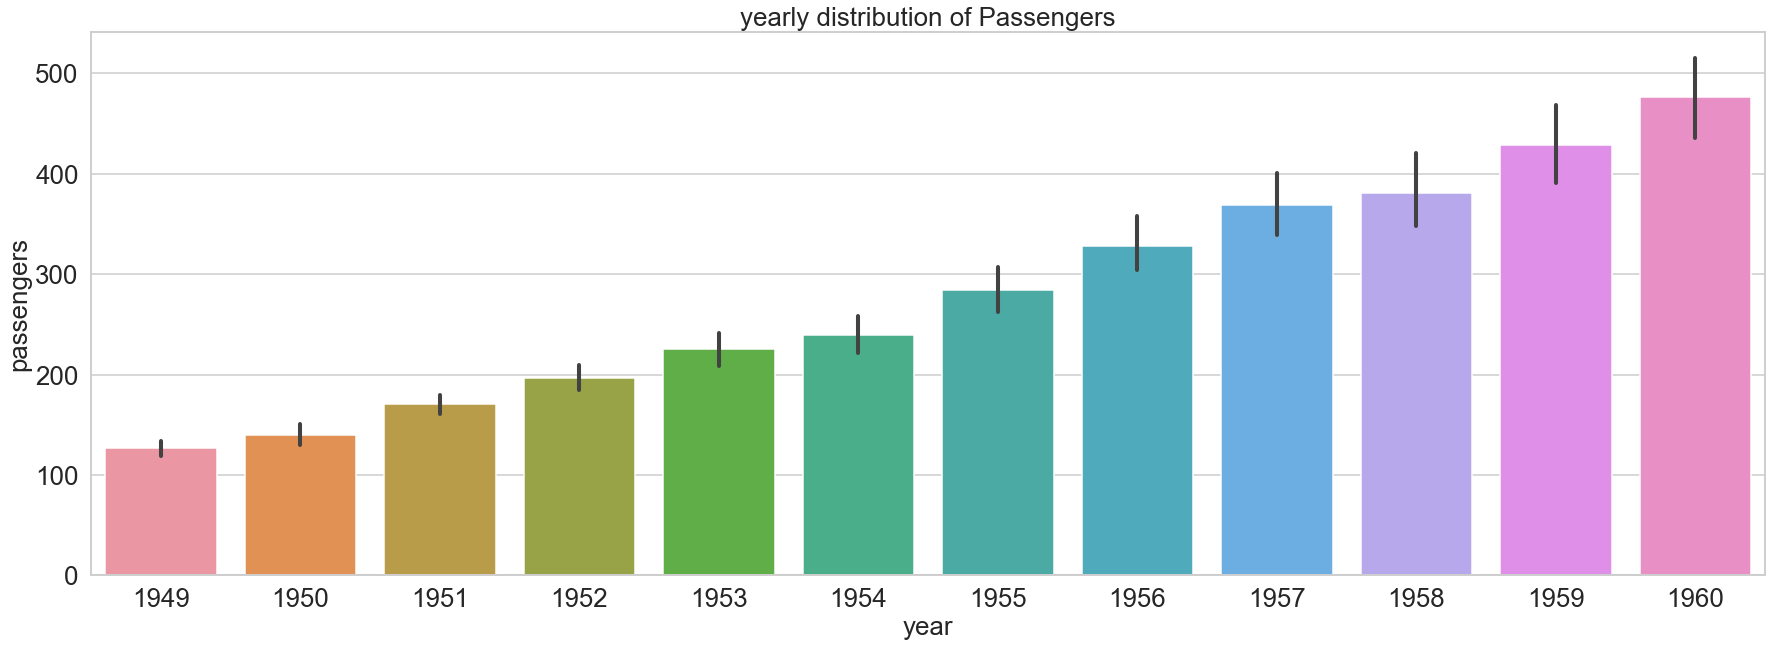

In [8]:
ax= sns.barplot(data=data_o,x="year",y="passengers")
#ax.set(ylim=(0, 60000))
ax.set(title="yearly distribution of Passengers")

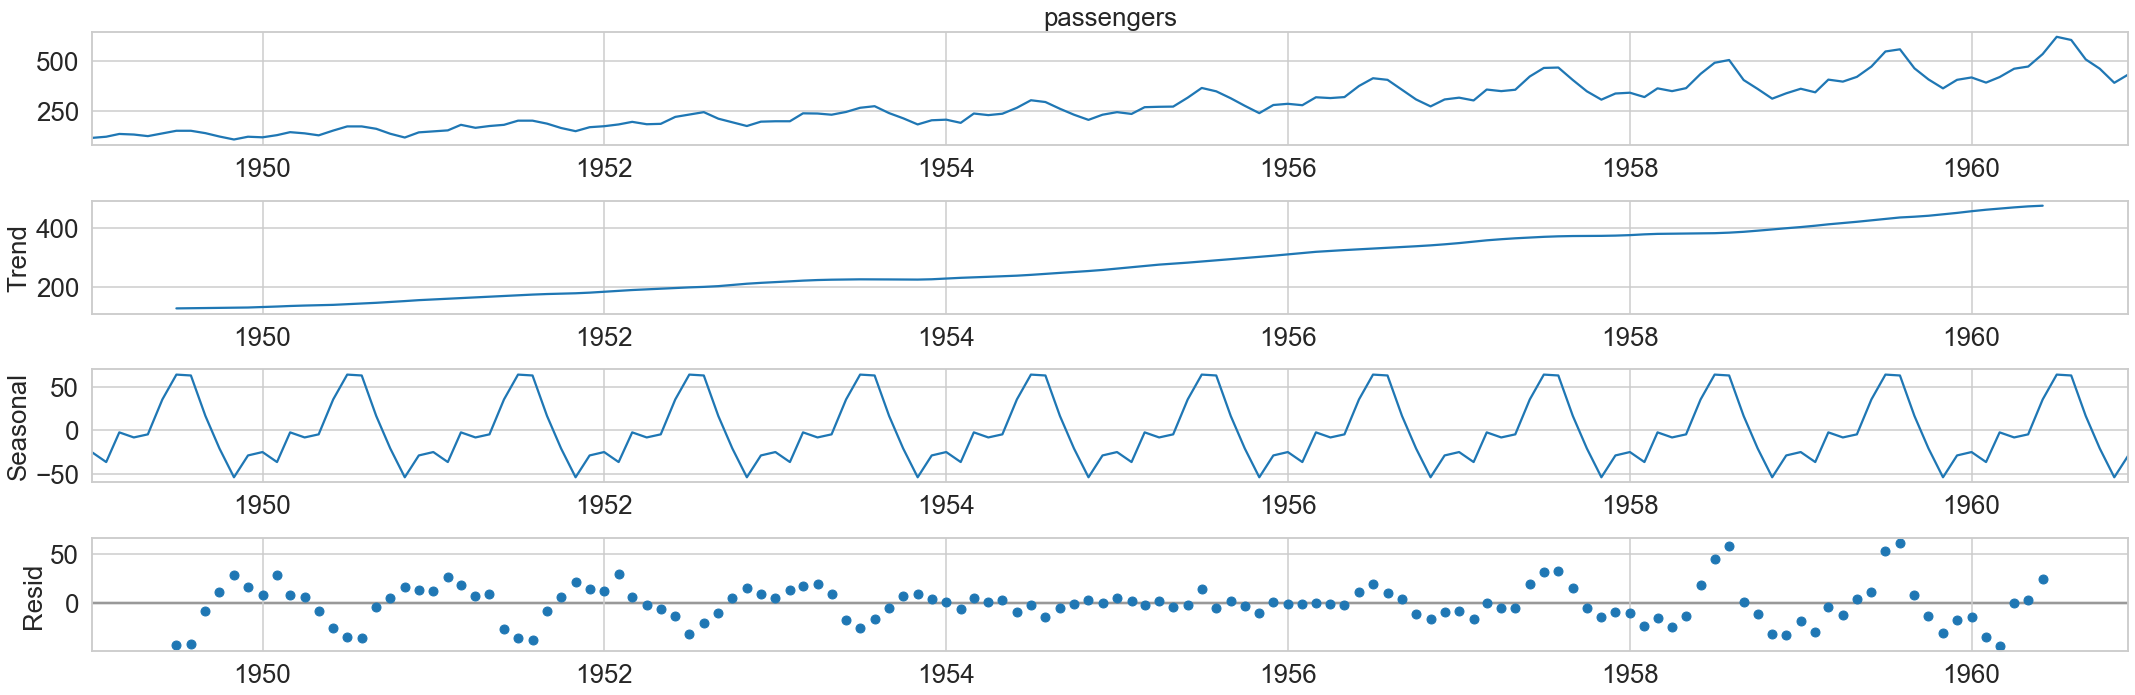

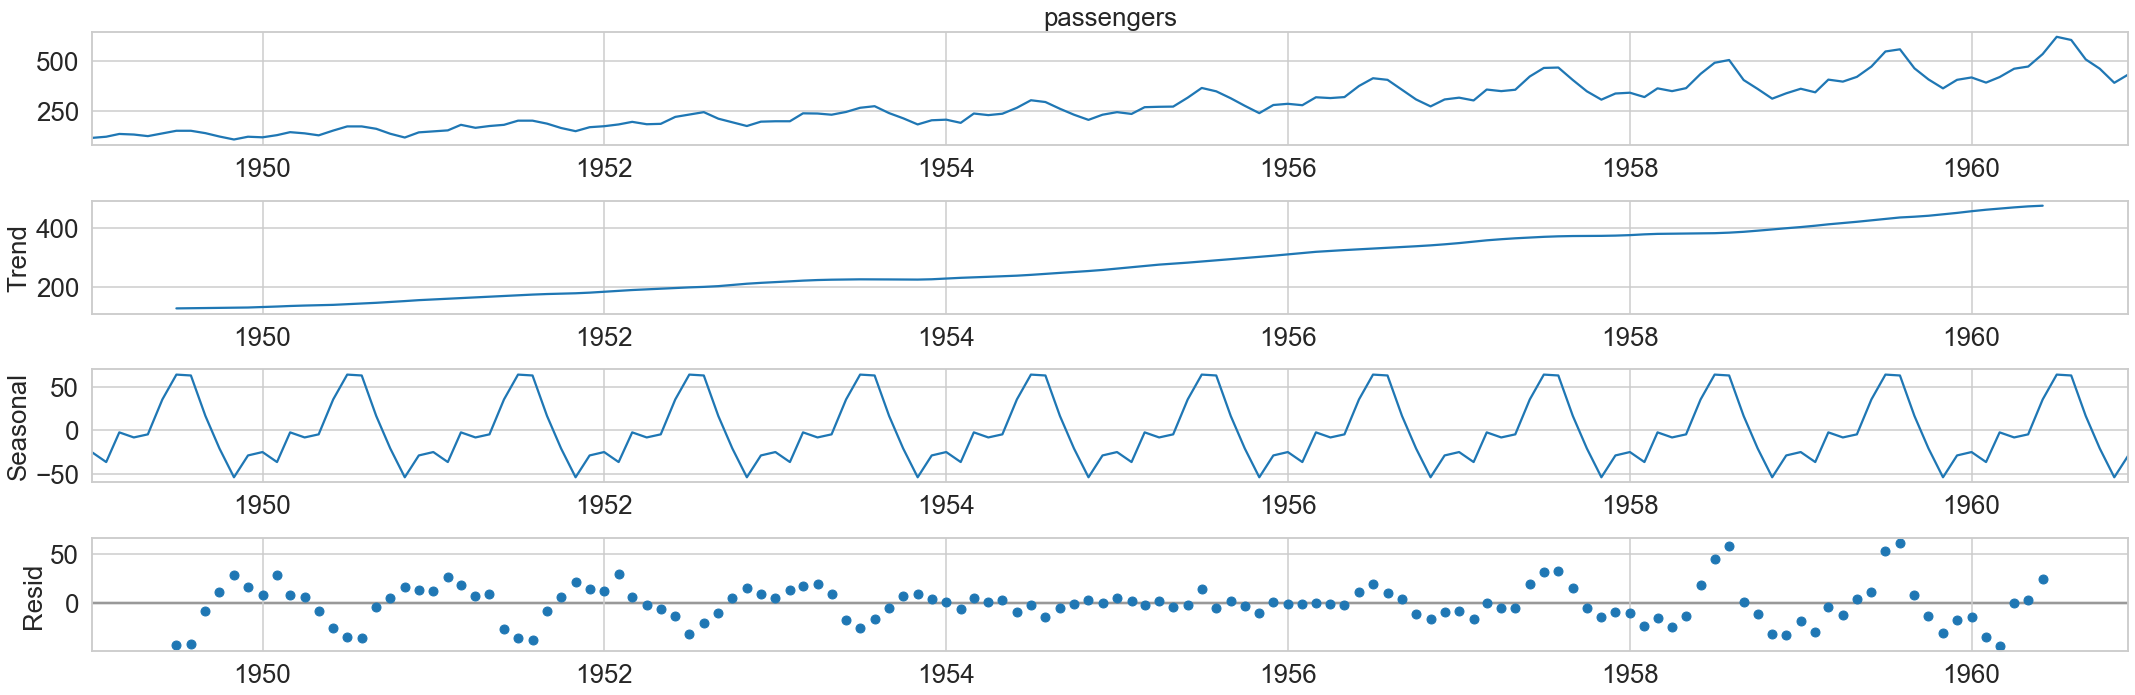

In [9]:
# Decompose time series data
decompose = seasonal_decompose(data_o.passengers)
decompose.plot()

# Looking at below plots its appears that series is non-stationary

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


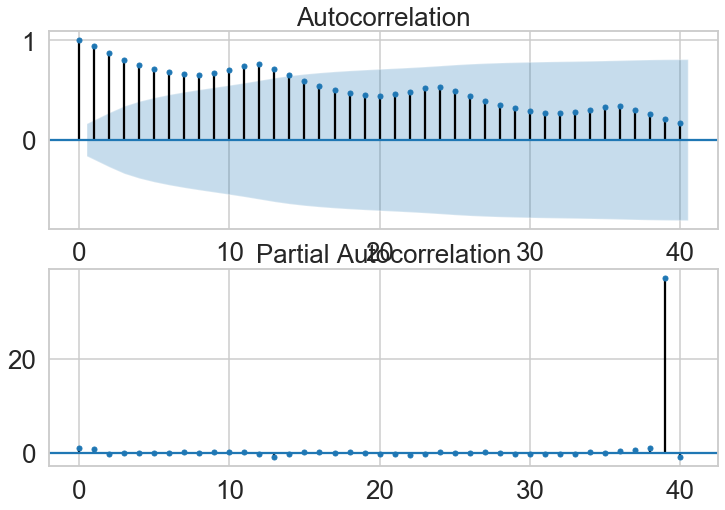

In [10]:
def plot_acf_pacf(series):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)    
    
plot_acf_pacf(data_o['passengers'])


# Augmented Dickey Fuller test (ADF Test) to test if Time series is stationary or not

In [11]:
# To determine the number of differencing required to make the series stationary.
# Dickey Fuller test for Stationarity
def ad_fuller_test(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
ad_fuller_test(data_o.passengers)

# Null hypothesis: series is non-stationary.
#Alternate hypothesis: series is stationary.

# When the test statistic is lower than the critical value shown, you reject the null hypothesis
# and infer that the time series is stationary.

# Since the "Test Statistic" is greater than the critical value(s) we do not reject null hypothesis.
# So we accept null hypothesis that series is non-stationary. 



Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ...

Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

In [12]:
# Make the time series stationary by differencing. 
log_series = np.log(data_o.passengers)
# Using log series with a shift to make it stationary
log_series_shift = log_series - log_series.shift(2)
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]
ad_fuller_test(log_series_shift)

#test statistic -3.167907 is lower than the critical value -2.884042 shown, you reject the null hypothesis
# With 1st order diffrencing series is still non-stationary, with 2nd order differencing series became stationary.

Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


2
(142, 5)


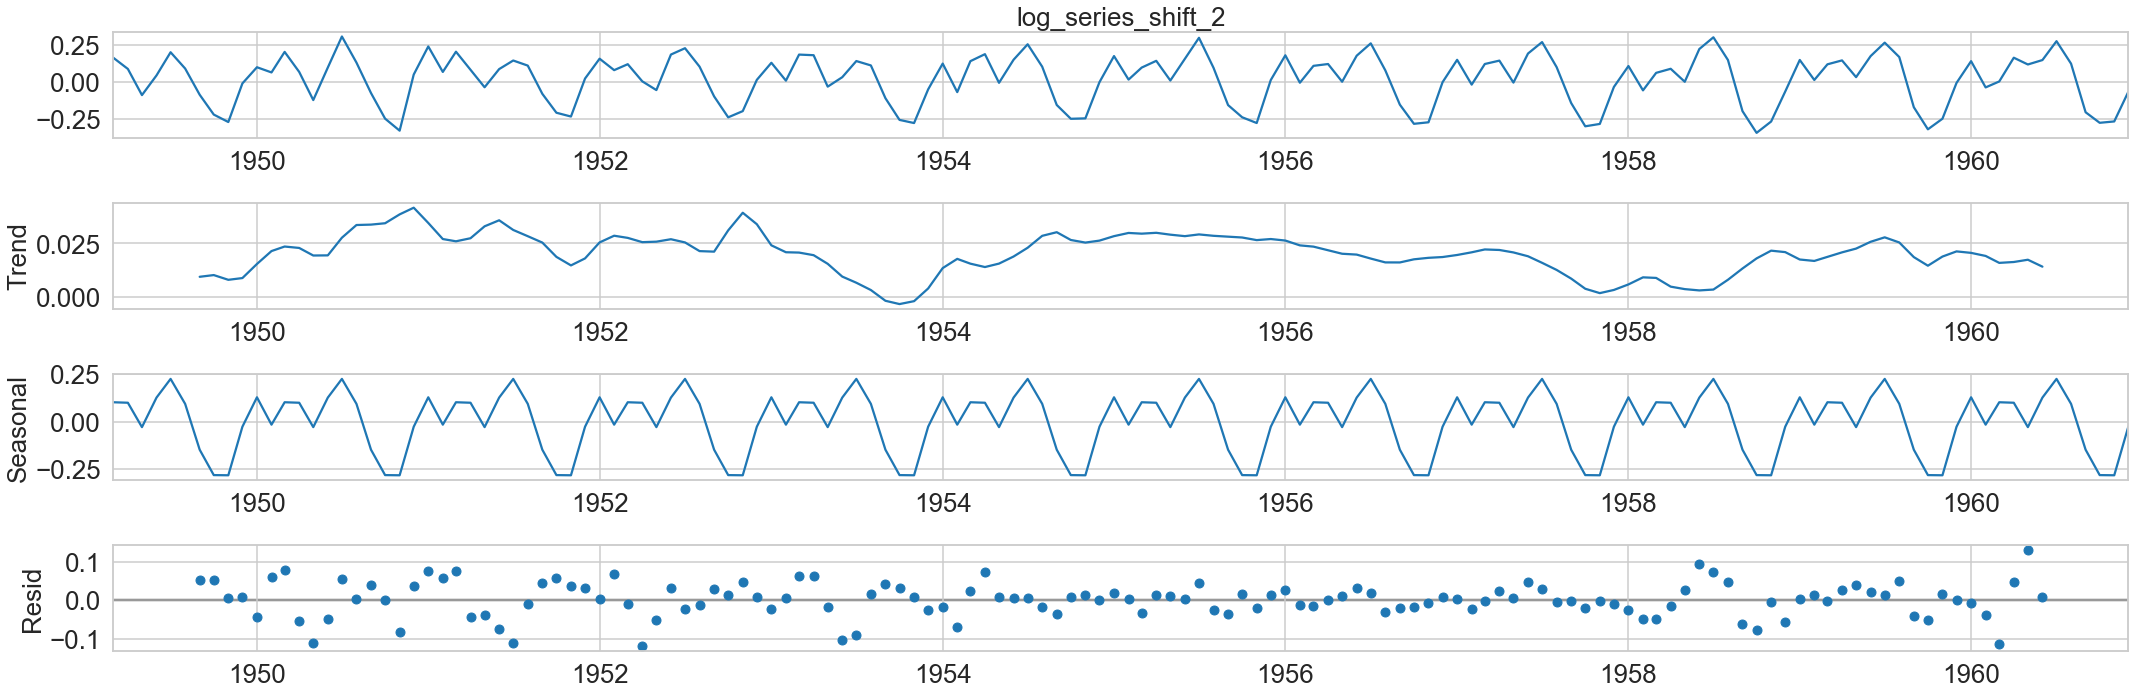

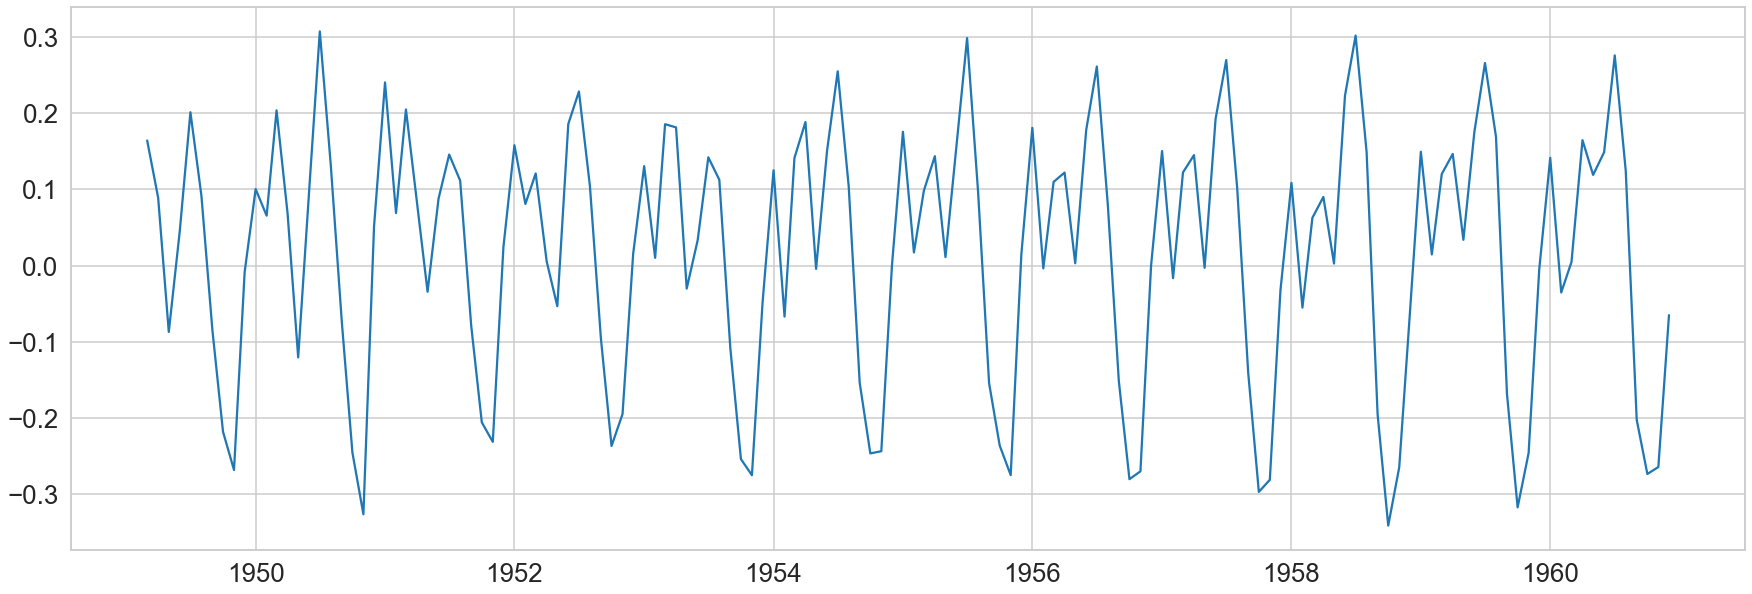

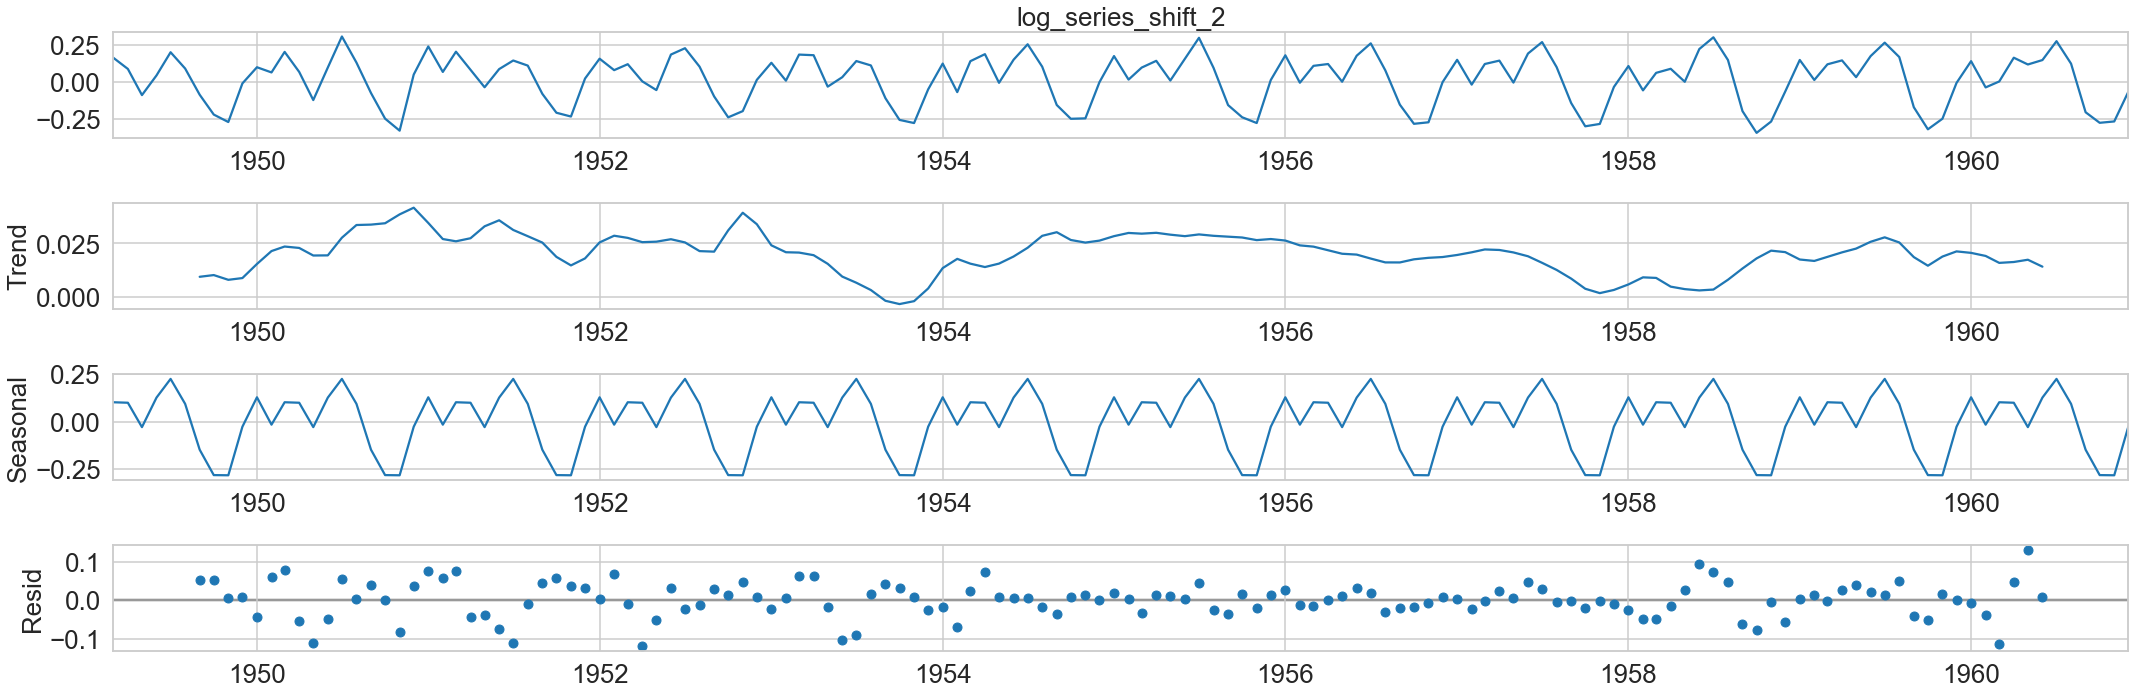

In [13]:
data_o['log_series_shift_2'] = log_series_shift
plt.plot(data_o['log_series_shift_2'])

print(data_o['log_series_shift_2'].isnull().sum()) # 2 null values

data_o.dropna(inplace = True) 
print(data_o.shape)

decompose = seasonal_decompose(data_o.log_series_shift_2)
decompose.plot()

# As we can see in below plots trend and seasonality has been negated. Now we need to figure out AR(p) and MA(q) values,
# from ACF and pacf plots. As d is 2.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


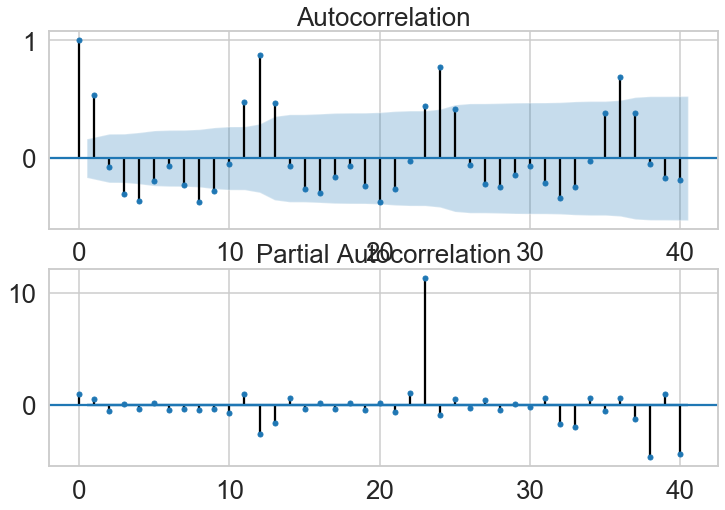

In [14]:
def plot_acf_pacf(series):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)    
    
plot_acf_pacf(data_o['log_series_shift_2'])

# From pacf we can determine AR(p), by looking at below pacf 3 are significant p=23 can be tried,
  # but it depends on older lags gerater than 12, so model can become complex, so use 0.
# From acf we can determine MA(q), by looking at below acf plot there are 10+ significant lags
  #q=10 or 11, but our model will become complex, so better to use simpler model.
# So try p=0, d=2, q=0
# But you can employ grid search to detremine best parameters for p & q

In [42]:
#Train test Split
print(data_o.shape)
train, test = data_o[0:136], data_o[136:len(data_o['passengers'])]
print(train.shape)
print(test.shape)

(142, 5)
(136, 5)
(6, 5)


In [51]:
param = (0,2,1)
mod = sm.tsa.statespace.SARIMAX(train['passengers'], order=param,seasonal_order = (0,2,1,12),nforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}- AIC:{}'.format(param, results.aic))

# We are fitting ARIMA to orginal non-differenced series. We differenced(shifted) and visulaized "log_series_shift_2" to 
# determine/judge values of p,d,q, but not to fit arima on "log_series_shift_2" . ARIMA will do the differencing on the 
#given (original) series


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)- AIC:901.9327661225074


# Forecast for next 6 timesteps (In months )

In [54]:
pred_uc_95 = results.get_forecast(steps=6, alpha=0.05) # alpha=0.05 95% CI
pred_ci_95 =pred_uc_95.conf_int()
pred_ci_95.head(6)

,lower passengers,upper passengers
1960-07-01,592.334895,642.804173
1960-08-01,593.808412,666.069506
1960-09-01,481.021725,570.595940
1960-10-01,413.850447,518.505932
1960-11-01,359.266940,477.628071
1960-12-01,399.055918,530.179145


In [47]:
test.head(6)

,passengers,month,quarter,year,log_series_shift_2
time,,,,,
1960-07-01,622,7,3,1960,0.275961
1960-08-01,606,8,3,1960,0.124613
1960-09-01,508,9,3,1960,-0.202459
1960-10-01,461,10,4,1960,-0.273482
1960-11-01,390,11,4,1960,-0.264335
1960-12-01,432,12,4,1960,-0.064972


In [57]:
ypred = pred_uc_95.predicted_mean
yactual = test.passengers
pd.concat([yactual,ypred], axis=1)

,passengers,0
1960-07-01,622,617.569534
1960-08-01,606,629.938959
1960-09-01,508,525.808832
1960-10-01,461,466.178189
1960-11-01,390,418.447505
1960-12-01,432,464.617532


# Evaluate Forecasts

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(yactual, ypred))
print('RMSE: %.3f' % rmse)

RMSE: 21.640


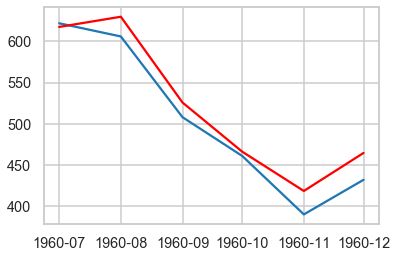

In [64]:
# plot forecasts against actual outcomes
plt.plot(yactual)
plt.plot(ypred, color='red')
plt.show()

# Predicting Airpassengers using Regression

In [97]:
#Fetuare engineering with rolling window statistics
data_o = pd.read_csv('Untitled Folder/AirPassengers.csv')
#select a window size, take the average,min,max of the values in the window, and use it as features
width = 2
shifted = passengers.shift(width - 1)
window = shifted.rolling(window=width)
data_o['mean'] = window.mean()
data_o['min'] = window.min()
data_o['max'] = window.max()
# Convert timestamp into a pandas datatime object
data_o['time'] = pd.to_datetime(data_o['time'])
data_o = data_o.set_index('time')
data_o.dropna(inplace = True) 
print(data_o.shape)
data_o.head()

(142, 4)


,passengers,mean,min,max
time,,,,
1949-03-01,132,115.0,112.0,118.0
1949-04-01,129,125.0,118.0,132.0
1949-05-01,121,130.5,129.0,132.0
1949-06-01,135,125.0,121.0,129.0
1949-07-01,148,128.0,121.0,135.0


In [98]:
#Train test split
X_train, X_test = data_o[0:136], data_o[136:len(data_o['passengers'])]
print(X_train.shape)
print(X_test.shape)
#Extract Target var from train data
y_train = X_train.passengers
#Drop target feature(passengers) from train and test data
X_train = X_train.drop(['passengers'],axis=1)
y_actual = X_test.passengers
X_test = X_test.drop(['passengers'],axis=1)
X_train.head()
#X_train.isnull().sum()

(136, 4)
(6, 4)


,mean,min,max
time,,,
1949-03-01,115.0,112.0,118.0
1949-04-01,125.0,118.0,132.0
1949-05-01,130.5,129.0,132.0
1949-06-01,125.0,121.0,129.0
1949-07-01,128.0,121.0,135.0


In [99]:
import lightgbm as lgb
#Train the model and predict passengers number of passengers for next 6 months
lgb_train = lgb.Dataset(X_train, y_train)
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression'    
}
gbm = lgb.train(params,lgb_train)
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 136, number of used features: 3
[LightGBM] [Info] Start training from score 272.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [100]:
#Evaluate TS Regression model
from sklearn.metrics import mean_squared_error
from math import sqrt
#y_pred = pd.Series(y_pred)
rmse = sqrt(mean_squared_error(y_actual, y_pred))
print('RMSE: %.3f' % rmse)




RMSE: 106.220


Solving Air Passengers forcasting as a supervised ML problem in this scenrio predicted same values (440.8135) for next 6 months.
Here its just a demonstartion. If we can engineer better features, Supervised LGBM may perform better.

TS forecasting with ARIMA has low RMSE value than LGBM model. Hence ARIMA  perfomed better. 

# Using TS fresh to Generate features

In [40]:
fc_parameters = { "mean": None,
                    'quantile': [{'q': 0.25},
                                  {'q': 0.75}],

                }


#X = extract_features(data_o, column_id="id", column_sort="time", column_value="value", impute_function=impute,show_warnings=False)

#X = extract_features(data_o, column_id="time", column_sort="time", column_value="passengers",default_fc_parameters=EfficientFCParameters(),show_warnings=False)
# extract_relevant_features: perform the extraction, imputing and filtering at the same time
X = extract_features(df_regress, column_id="time", column_sort="time", column_value="passengers",default_fc_parameters=fc_parameters,show_warnings=False)

X.head() # (144,7)

Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.72it/s]


,passengers__mean,passengers__quantile__q_0.25,passengers__quantile__q_0.75
1949-01,112.0,112.0,112.0
1949-02,118.0,118.0,118.0
1949-03,132.0,132.0,132.0
1949-04,129.0,129.0,129.0
1949-05,121.0,121.0,121.0


In [96]:
df_training = pd.read_csv('Untitled Folder/power-laws-forecasting-energy-consumption-training-data.csv',sep=';',index_col=0)
#df_weather = pd.read_csv('Untitled Folder/power-laws-forecasting-energy-consumption-weather.csv',sep=';')
#df_metadata = pd.read_csv('Untitled Folder/power-laws-forecasting-energy-consumption-metadata.csv',sep=';')
print(df_training.shape)
#print(df_weather.shape)
#print(df_metadata.shape)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(6559830, 4)


* There are 86601 nulls in target feature "Value": df_training.isnull().sum()
* There are 267 sites, so 267 timeseries we need to forecast : len(df_training.SiteId.unique())
* There are 6974 unique ForecastId's
* df_training.SiteId.value_counts() gives you number of rows in each time series, just pick top 4 sites with max rows.
* On weekends 6-sunday the energy consumption by hour is the same.
* On weekends 5-Sat, 6-Sun energy consumption is low.
* On Friday enregy consumption is max.
* Energy Consumption is more in October month.
* 582693 null values in temperature feature.

In [81]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6559830 entries, 4852050 to 637308
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SiteId      int64  
 1   Timestamp   object 
 2   ForecastId  int64  
 3   Value       float64
dtypes: float64(1), int64(2), object(1)
memory usage: 250.2+ MB


In [82]:
df_training.describe()

,SiteId,ForecastId,Value
count,6.559830e+06,6.559830e+06,6.473229e+06
mean,1.620964e+02,3.482184e+03,3.560104e+05
std,9.392171e+01,2.009486e+03,3.309454e+08
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.700000e+01,1.744000e+03,3.492465e+03
50%,1.730000e+02,3.489000e+03,1.408683e+04
75%,2.370000e+02,5.216000e+03,4.649371e+04
max,3.050000e+02,6.974000e+03,6.404683e+11


In [83]:
df_training.head()

,SiteId,Timestamp,ForecastId,Value
obs_id,,,,
4852050,42,2016-10-18T02:45:00+00:00,1087,26397.049623
1638923,42,2016-10-18T11:45:00+00:00,1087,42958.364641
5748910,42,2016-10-18T20:45:00+00:00,1087,27096.919666
38199,42,2016-10-20T10:45:00+00:00,1087,50211.408087
1338204,42,2016-10-20T18:45:00+00:00,1087,50503.305105


In [84]:
df_training.SiteId.value_counts()

302    223648
261    156168
6      140744
269    127248
271    125320
        ...  
211       360
78        360
244       360
172       360
182       360
Name: SiteId, Length: 267, dtype: int64

In [97]:
# Filter rows other than 302,261,6,269. We will work with only these 4 siteids/sites/buldings
sitedids = [302,261,6,269]
df_training = df_training.loc[df_training['SiteId'].isin(sitedids)] # (647808, 4)

#3883 nulls in target value feature
# Convert timestamp into a pandas datatime object
df_training['Timestamp'] = pd.to_datetime(df_training['Timestamp'])
df_training = df_training.set_index('Timestamp')

df_training.head()

,SiteId,ForecastId,Value
Timestamp,,,
2017-09-30 01:30:00+00:00,269,5782,779.486534
2017-09-30 02:00:00+00:00,269,5782,774.674888
2017-09-30 06:45:00+00:00,269,5782,774.674888
2017-09-30 11:15:00+00:00,269,5782,6486.097822
2017-09-30 18:15:00+00:00,269,5782,6115.601136


In [98]:
# Extract units of time from the timestamp. By default in pandas when we extract weekday from date, 0 is Monday
df_training['min'] = df_training.index.minute # Has [30,  0, 45, 15] unique values
df_training['hour'] = df_training.index.hour
df_training['wday'] = df_training.index.dayofweek
df_training['wdayname'] = df_training.index.strftime('%A')
df_training['mday'] = df_training.index.day
df_training['yday'] = df_training.index.dayofyear
df_training['month'] = df_training.index.month
df_training['year'] = df_training.index.year

 # wday has period of 6
df_training['wday_sin'] = np.sin(2 * np.pi * df_training['wday'] / 6)
df_training['wday_cos'] = np.cos(2 * np.pi * df_training['wday'] / 6)
    
print(pd.DataFrame(pd.concat([pd.Series(df_training['wday'].unique()),
      pd.Series(df_training['wdayname'].unique())], axis=1)).sort_values(by=0))
df_training.head()

   0          1
2  0     Monday
3  1    Tuesday
6  2  Wednesday
4  3   Thursday
5  4     Friday
0  5   Saturday
1  6     Sunday


,SiteId,ForecastId,Value,min,hour,wday,wdayname,mday,yday,month,year,wday_sin,wday_cos
Timestamp,,,,,,,,,,,,,
2017-09-30 01:30:00+00:00,269,5782,779.486534,30,1,5,Saturday,30,273,9,2017,-0.866025,0.5
2017-09-30 02:00:00+00:00,269,5782,774.674888,0,2,5,Saturday,30,273,9,2017,-0.866025,0.5
2017-09-30 06:45:00+00:00,269,5782,774.674888,45,6,5,Saturday,30,273,9,2017,-0.866025,0.5
2017-09-30 11:15:00+00:00,269,5782,6486.097822,15,11,5,Saturday,30,273,9,2017,-0.866025,0.5
2017-09-30 18:15:00+00:00,269,5782,6115.601136,15,18,5,Saturday,30,273,9,2017,-0.866025,0.5


In [99]:
print(df_training['min'].unique())
# Create a time of day to represent hours and minutes
df_training['time'] = df_training['hour'] + (df_training['min'] / 60)
df_training['time'].head(20)

[30  0 45 15]


Timestamp
2017-09-30 01:30:00+00:00     1.50
2017-09-30 02:00:00+00:00     2.00
2017-09-30 06:45:00+00:00     6.75
2017-09-30 11:15:00+00:00    11.25
2017-09-30 18:15:00+00:00    18.25
2017-09-30 22:30:00+00:00    22.50
2017-10-01 02:00:00+00:00     2.00
2017-10-01 05:00:00+00:00     5.00
2017-10-01 09:30:00+00:00     9.50
2017-10-01 11:45:00+00:00    11.75
2017-10-01 14:30:00+00:00    14.50
2017-10-01 18:00:00+00:00    18.00
2017-10-01 18:45:00+00:00    18.75
2017-10-01 20:00:00+00:00    20.00
2017-10-02 00:30:00+00:00     0.50
2017-10-02 08:45:00+00:00     8.75
2017-10-02 15:00:00+00:00    15.00
2017-10-02 15:15:00+00:00    15.25
2017-10-02 20:30:00+00:00    20.50
2017-10-03 02:00:00+00:00     2.00
Name: time, dtype: float64

# Univariate Analysis of training data
https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

https://towardsdatascience.com/formating-and-visualizing-time-series-data-ba0b2548f27b

[Text(0.5, 1.0, 'Weekly distribution of energy consumption/value (all sites)')]

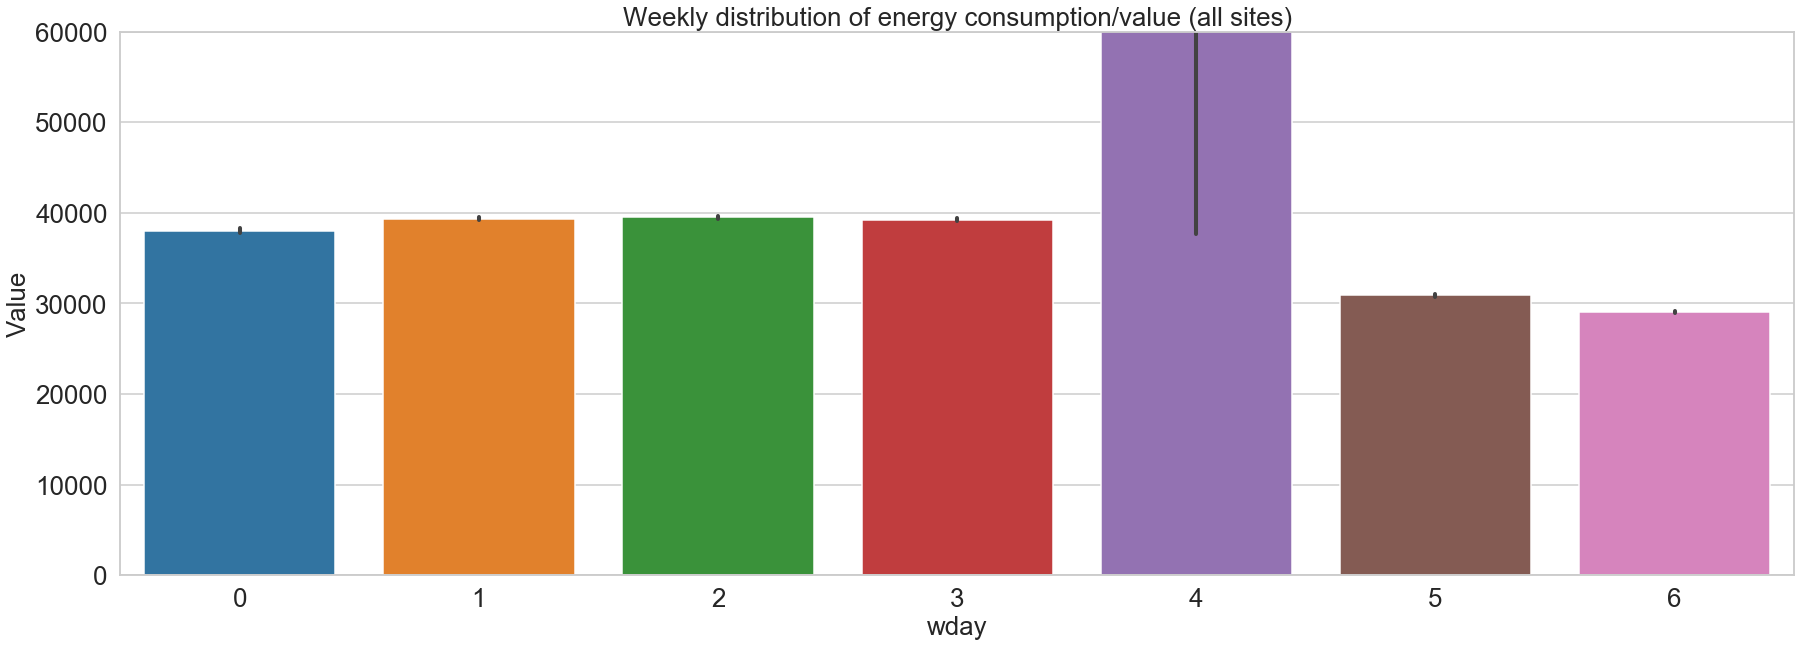

In [73]:
ax= sns.barplot(data=df_training,x="wday",y="Value")
ax.set(ylim=(0, 60000))
ax.set(title="Weekly distribution of energy consumption/value (all sites)")

[Text(0.5, 1.0, 'Monthly distribution of energy consumption/value (all sites)')]

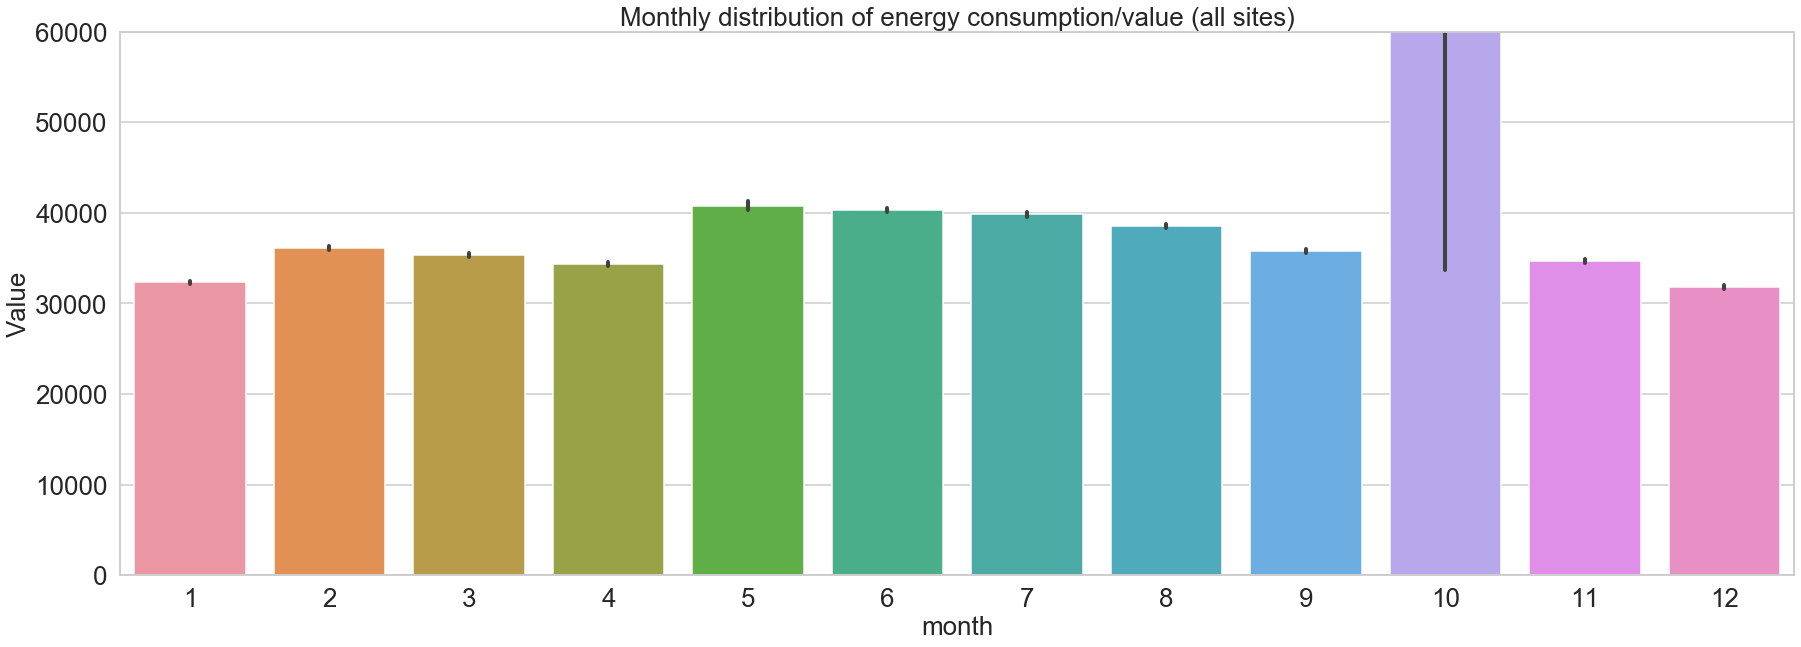

In [74]:
ax= sns.barplot(data=df_training,x="month",y="Value")
ax.set(ylim=(0, 60000))
ax.set(title="Monthly distribution of energy consumption/value (all sites)")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


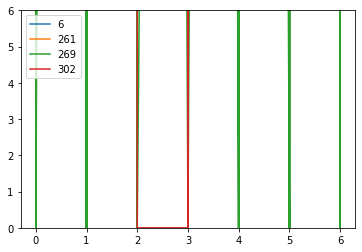

In [12]:
#One plot for multiple sites/timeseries
by_site = df_training.groupby('SiteId')

for name, group in by_site:
    plt.plot(group['wday'], group['Value'], label=name)

plt.legend()
plt.ylim(0.0,6.0)
plt.show()

[Text(0.5, 1.0, 'Weekday wise hourly distribution of energy consumption (all sites)')]

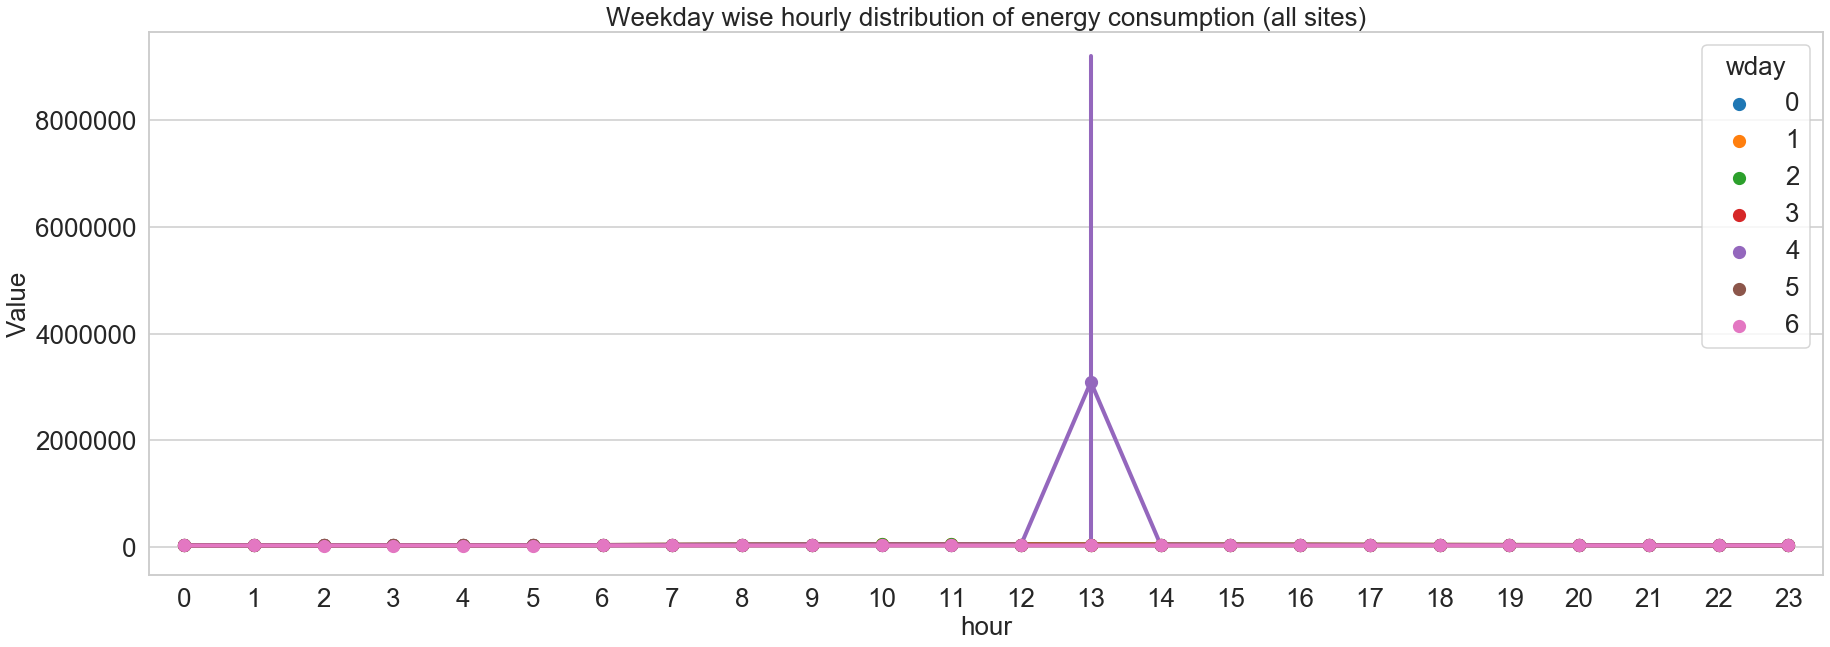

In [44]:
fig,ax = plt.subplots()
sns.pointplot(data=df_training,x='hour',y='Value',hue='wday',ax=ax)
ax.set(title="Weekday wise hourly distribution of energy consumption (all sites)")

[Text(0.5, 1.0, 'Box Pot for hourly distribution of energy consumption (all sites)')]

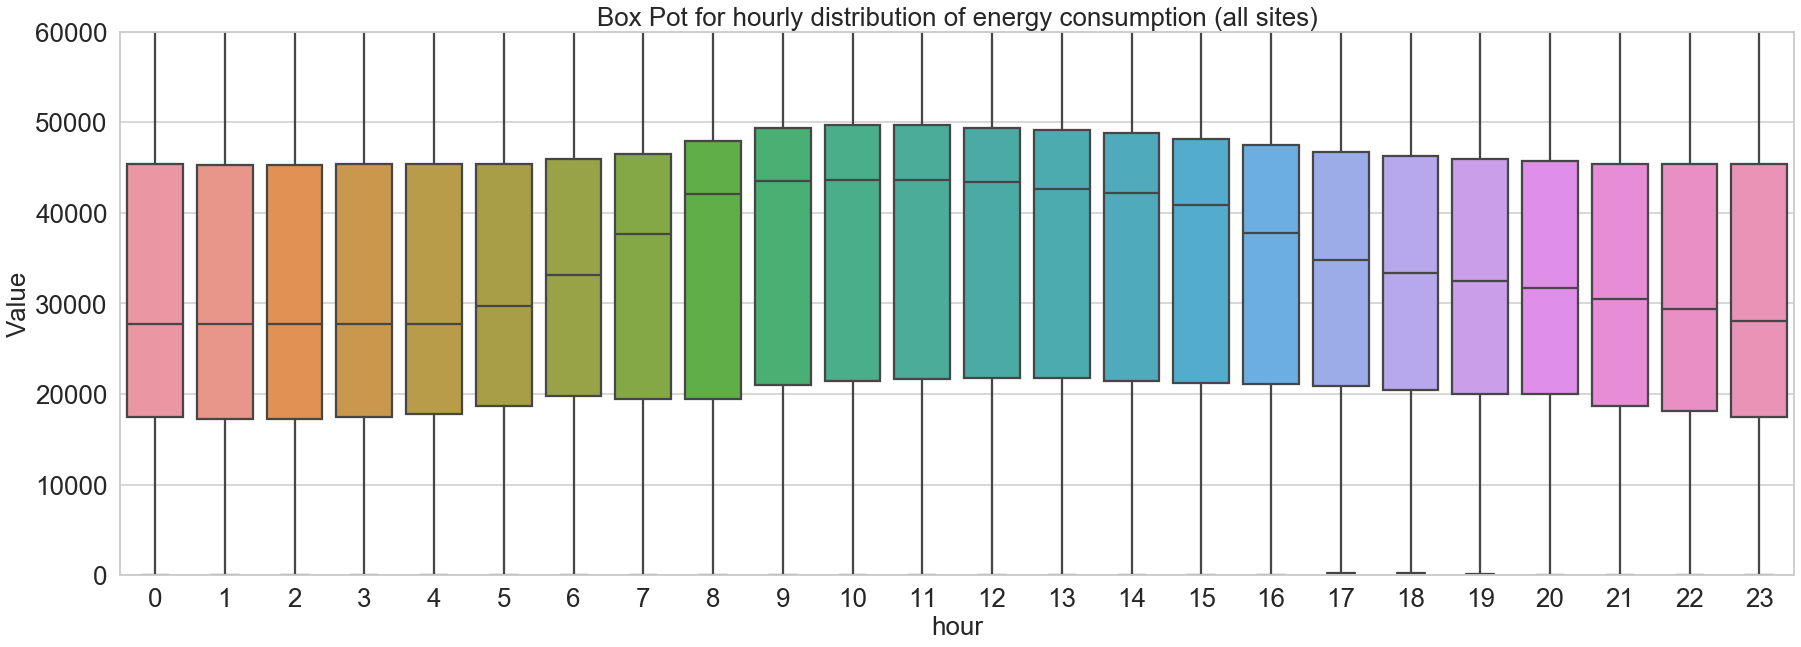

In [46]:
fig,ax = plt.subplots()
sns.boxplot(data=df_training,x='hour',y='Value',ax=ax)
ax.set(ylim=(0, 60000))
ax.set(title="Box Plot for hourly distribution of energy consumption (all sites) ")

[(0, 20000)]

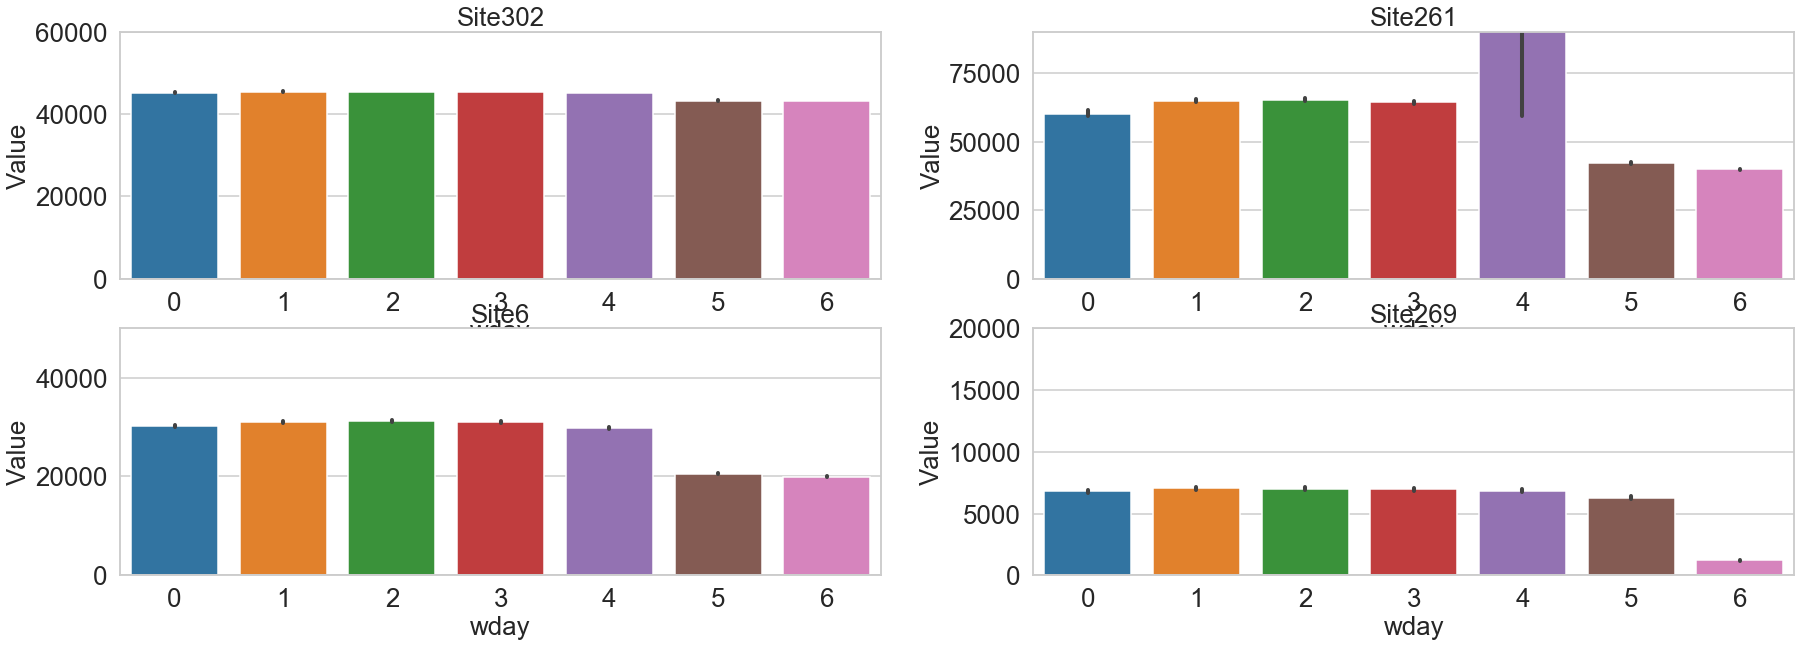

In [27]:
#[302,261,6,269]
df_col_list = ['wday','hour','Value']
plot_col_list= ['wday','Value']
df_302 = df_training[df_training.SiteId==302][df_col_list]
df_261 = df_training[df_training.SiteId==261][df_col_list]
df_6 = df_training[df_training.SiteId==6][df_col_list]
df_269 = df_training[df_training.SiteId==269][df_col_list]

fig,ax= plt.subplots(nrows=2,ncols=2)
sns.barplot(data=df_302[plot_col_list],x="wday",y="Value",ax=ax[0][0])
ax[0][0].set(title="Site302")
ax[0][0].set(ylim=(0, 60000))

sns.barplot(data=df_261[plot_col_list],x="wday",y="Value",ax=ax[0][1])
ax[0][1].set(title="Site261")
ax[0][1].set(ylim=(0, 90000))

sns.barplot(data=df_6[plot_col_list],x="wday",y="Value",ax=ax[1][0])
ax[1][0].set(title="Site6")
ax[1][0].set(ylim=(0, 50000))

sns.barplot(data=df_269[plot_col_list],x="wday",y="Value",ax=ax[1][1])  
ax[1][1].set(title="Site269")
ax[1][1].set(ylim=(0, 20000))

[(0, 20000)]

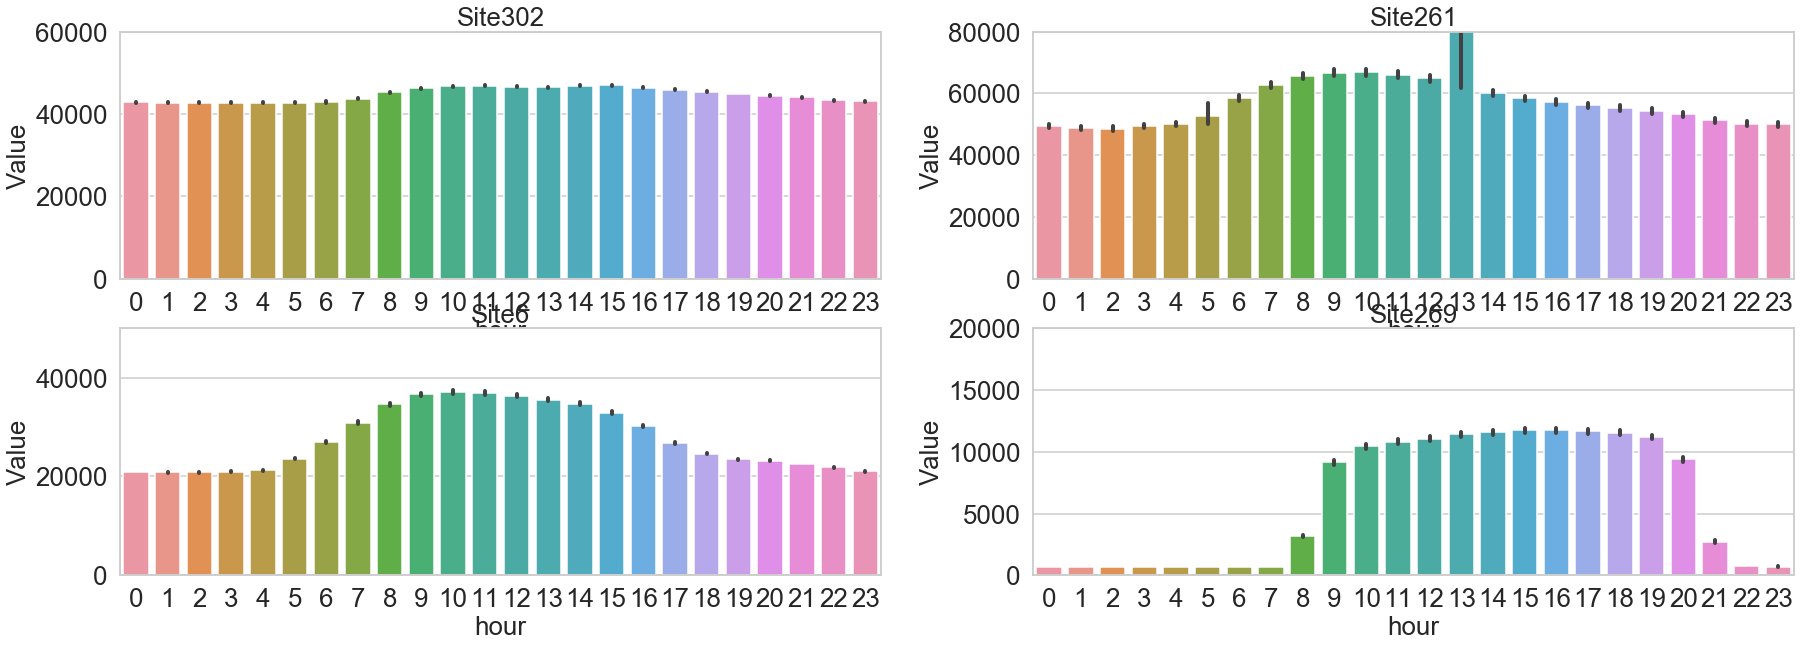

In [28]:
df_col_list = ['wday','hour','Value']
plot_col_list= ['hour','Value']
df_302 = df_training[df_training.SiteId==302][df_col_list]
df_261 = df_training[df_training.SiteId==261][df_col_list]
df_6 = df_training[df_training.SiteId==6][df_col_list]
df_269 = df_training[df_training.SiteId==269][df_col_list]

fig,ax= plt.subplots(nrows=2,ncols=2)
sns.barplot(data=df_302[plot_col_list],x="hour",y="Value",ax=ax[0][0],)
ax[0][0].set(title="Site302")
ax[0][0].set(ylim=(0, 60000))

sns.barplot(data=df_261[plot_col_list],x="hour",y="Value",ax=ax[0][1])
ax[0][1].set(title="Site261")
ax[0][1].set(ylim=(0, 80000))

sns.barplot(data=df_6[plot_col_list],x="hour",y="Value",ax=ax[1][0])
ax[1][0].set(title="Site6")
ax[1][0].set(ylim=(0, 50000))

sns.barplot(data=df_269[plot_col_list],x="hour",y="Value",ax=ax[1][1])  
ax[1][1].set(title="Site269")
ax[1][1].set(ylim=(0, 20000))

[(0, 20000)]

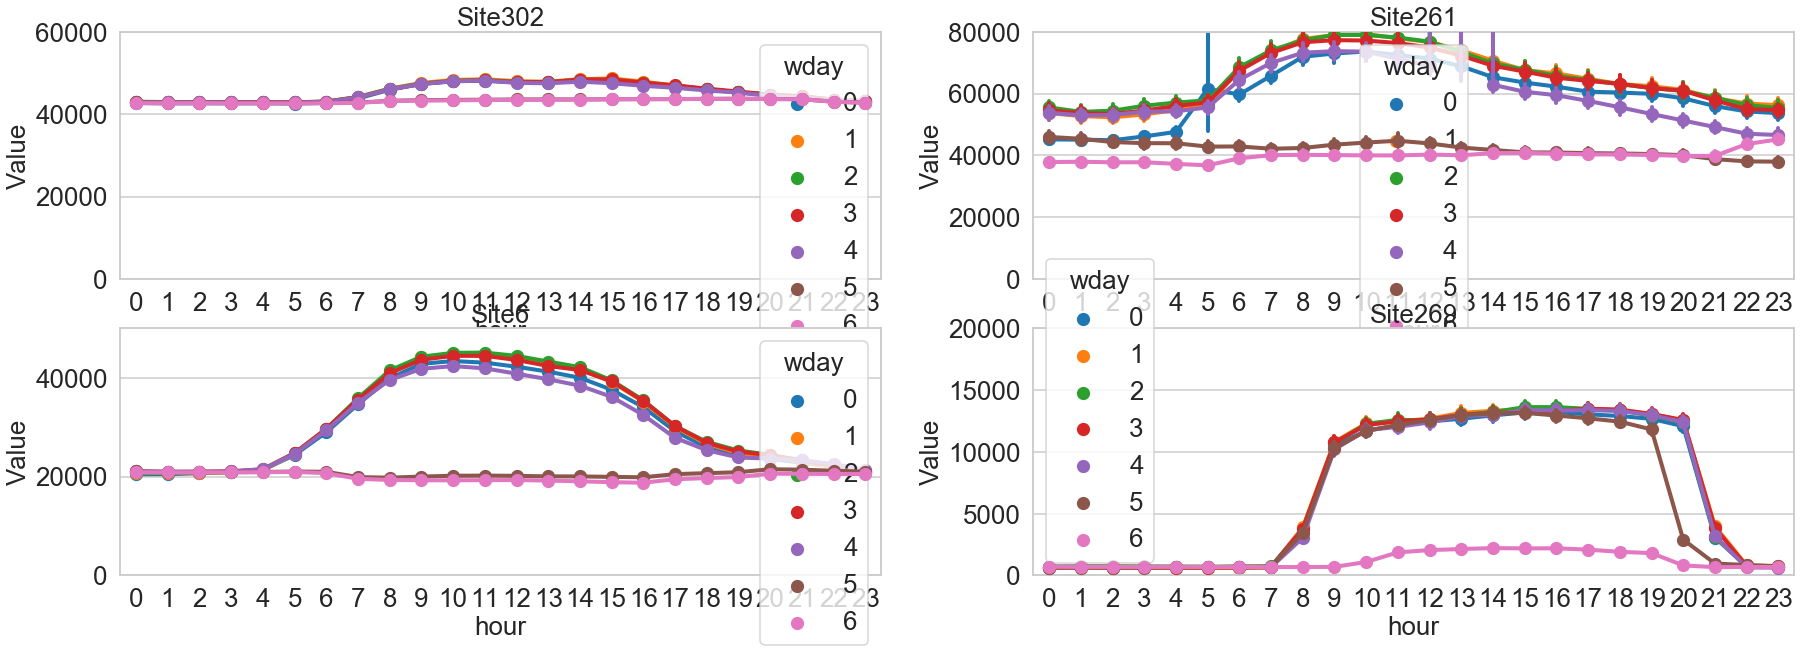

In [31]:
df_col_list = ['wday','hour','Value']

df_302 = df_training[df_training.SiteId==302][df_col_list]
df_261 = df_training[df_training.SiteId==261][df_col_list]
df_6 = df_training[df_training.SiteId==6][df_col_list]
df_269 = df_training[df_training.SiteId==269][df_col_list]

fig,ax= plt.subplots(nrows=2,ncols=2)
sns.pointplot(data=df_302[df_col_list],x='hour',y='Value',hue='wday',ax=ax[0][0])
ax[0][0].set(title="Site302")
ax[0][0].set(ylim=(0, 60000))

sns.pointplot(data=df_261[df_col_list],x='hour',y='Value',hue='wday',ax=ax[0][1])
ax[0][1].set(title="Site261")
ax[0][1].set(ylim=(0, 80000))

sns.pointplot(data=df_6[df_col_list],x='hour',y='Value',hue='wday',ax=ax[1][0])
ax[1][0].set(title="Site6")
ax[1][0].set(ylim=(0, 50000))

sns.pointplot(data=df_269[df_col_list],x='hour',y='Value',hue='wday',ax=ax[1][1])  
ax[1][1].set(title="Site269")
ax[1][1].set(ylim=(0, 20000))

In [1]:
import pandas as pd
import numpy as np

# Creating a datetimeindex with monthly frequency
df = pd.DataFrame(pd.date_range(start='1/1/20', end='1/1/21', freq='M'))
df["num"] = [1,2,3,4,5,6,7,8,9,10,11,12]
df.rename(columns={0:'date'}, inplace = True)
df

,date,num
0,2020-01-31,1
1,2020-02-29,2
2,2020-03-31,3
3,2020-04-30,4
4,2020-05-31,5
5,2020-06-30,6
6,2020-07-31,7
7,2020-08-31,8
8,2020-09-30,9
9,2020-10-31,10


In [2]:
# Feature engineering with Shift
df['lag1'] = df.num.shift()
df['lag2'] = df.num.shift(-1)
df

,date,num,lag1,lag2
0,2020-01-31,1,NaN,2.0
1,2020-02-29,2,1.0,3.0
2,2020-03-31,3,2.0,4.0
3,2020-04-30,4,3.0,5.0
4,2020-05-31,5,4.0,6.0
5,2020-06-30,6,5.0,7.0
6,2020-07-31,7,6.0,8.0
7,2020-08-31,8,7.0,9.0
8,2020-09-30,9,8.0,10.0
9,2020-10-31,10,9.0,11.0


In [3]:
#average of adjacent elements based on windowsize
df['Avgofadjelements'] = df.iloc[:,1].rolling(window=2).mean()
df

,date,num,lag1,lag2,Avgofadjelements
0,2020-01-31,1,NaN,2.0,NaN
1,2020-02-29,2,1.0,3.0,1.5
2,2020-03-31,3,2.0,4.0,2.5
3,2020-04-30,4,3.0,5.0,3.5
4,2020-05-31,5,4.0,6.0,4.5
5,2020-06-30,6,5.0,7.0,5.5
6,2020-07-31,7,6.0,8.0,6.5
7,2020-08-31,8,7.0,9.0,7.5
8,2020-09-30,9,8.0,10.0,8.5
9,2020-10-31,10,9.0,11.0,9.5


In [4]:
#Create a feature  with div of adjacent values
df['LastMonthByPrevMonth'] = df.num / df.num.shift(-1) 
df

,date,num,lag1,lag2,Avgofadjelements,LastMonthByPrevMonth
0,2020-01-31,1,NaN,2.0,NaN,0.500000
1,2020-02-29,2,1.0,3.0,1.5,0.666667
2,2020-03-31,3,2.0,4.0,2.5,0.750000
3,2020-04-30,4,3.0,5.0,3.5,0.800000
4,2020-05-31,5,4.0,6.0,4.5,0.833333
5,2020-06-30,6,5.0,7.0,5.5,0.857143
6,2020-07-31,7,6.0,8.0,6.5,0.875000
7,2020-08-31,8,7.0,9.0,7.5,0.888889
8,2020-09-30,9,8.0,10.0,8.5,0.900000
9,2020-10-31,10,9.0,11.0,9.5,0.909091


In [5]:
#Create a feature  with div of adjacent values
df['LastMonthByPrevMonth'] = df.num / df.num.shift(-1) 
df

,date,num,lag1,lag2,Avgofadjelements,LastMonthByPrevMonth
0,2020-01-31,1,NaN,2.0,NaN,0.500000
1,2020-02-29,2,1.0,3.0,1.5,0.666667
2,2020-03-31,3,2.0,4.0,2.5,0.750000
3,2020-04-30,4,3.0,5.0,3.5,0.800000
4,2020-05-31,5,4.0,6.0,4.5,0.833333
5,2020-06-30,6,5.0,7.0,5.5,0.857143
6,2020-07-31,7,6.0,8.0,6.5,0.875000
7,2020-08-31,8,7.0,9.0,7.5,0.888889
8,2020-09-30,9,8.0,10.0,8.5,0.900000
9,2020-10-31,10,9.0,11.0,9.5,0.909091


In [6]:
# Creating a datetimeindex with weekly frequency
df_weekly = pd.DataFrame(pd.date_range(start='1/1/20', end='1/1/21', freq='W'))
df_weekly['value'] = np.random.randint(100, size=(52))
df_weekly.rename(columns={0:'date'}, inplace = True)
df_weekly.shape

(52, 2)

In [7]:
#create a feature with ratio of values from current week by prev week
df_weekly['lag1back'] = df_weekly.value.shift(-1).fillna(1).astype(np.int32)
df_weekly['lastweekByprevWeek'] = df_weekly['value']/df_weekly['lag1back']
df_weekly.head(8)

,date,value,lag1back,lastweekByprevWeek
0,2020-01-05,89,12,7.416667
1,2020-01-12,12,83,0.144578
2,2020-01-19,83,75,1.106667
3,2020-01-26,75,66,1.136364
4,2020-02-02,66,0,inf
5,2020-02-09,0,63,0.000000
6,2020-02-16,63,91,0.692308
7,2020-02-23,91,19,4.789474


In [8]:
#create a feature with ratio of sumof values from current month by prev month
df_weekly['month'] = df_weekly.date.dt.month
df_monthly_sum =pd.DataFrame(df_weekly.groupby('month').value.sum())
df_monthly_sum['lag1Bval'] =  df_monthly_sum.value.shift(-1).fillna(1)
df_monthly_sum['lastMonthByprevMonth'] = df_monthly_sum['value']/df_monthly_sum['lag1Bval']
#Convert month index as column
df_monthly_sum.reset_index(level=0, inplace=True)
df_monthly_sum

,month,value,lag1Bval,lastMonthByprevMonth
0,1,259,220.0,1.177273
1,2,220,288.0,0.763889
2,3,288,168.0,1.714286
3,4,168,201.0,0.835821
4,5,201,190.0,1.057895
5,6,190,167.0,1.137725
6,7,167,250.0,0.668000
7,8,250,236.0,1.059322
8,9,236,118.0,2.000000
9,10,118,217.0,0.543779


In [9]:
df_merged = pd.merge(df_weekly, df_monthly_sum, how='left', on=['month'])
df_merged.head(12) 

,date,value_x,lag1back,lastweekByprevWeek,month,value_y,lag1Bval,lastMonthByprevMonth
0,2020-01-05,89,12,7.416667,1,259,220.0,1.177273
1,2020-01-12,12,83,0.144578,1,259,220.0,1.177273
2,2020-01-19,83,75,1.106667,1,259,220.0,1.177273
3,2020-01-26,75,66,1.136364,1,259,220.0,1.177273
4,2020-02-02,66,0,inf,2,220,288.0,0.763889
5,2020-02-09,0,63,0.000000,2,220,288.0,0.763889
6,2020-02-16,63,91,0.692308,2,220,288.0,0.763889
7,2020-02-23,91,19,4.789474,2,220,288.0,0.763889
8,2020-03-01,19,67,0.283582,3,288,168.0,1.714286
9,2020-03-08,67,98,0.683673,3,288,168.0,1.714286
